In [1]:
import os
import shutil
directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_results'
subject1 = 'experiment_result_JayShenoy'
subject2 = 'experiment_result_TaeSung'
subject3 = 'experiment_result_Xiangyu'
scenario_list = ['scenario1','scenario2','scenario3','scenario4','scenario5']

for scenario_name in scenario_list:
    dir1 = os.path.join(directory, subject1, scenario_name)
    dir2 = os.path.join(directory, subject2, scenario_name)
    dir3 = os.path.join(directory, subject3, scenario_name)

    files1 = set([file for file in os.listdir(dir1) if file.endswith('.jpg')])
    files2 = set([file for file in os.listdir(dir2) if file.endswith('.jpg')])
    files3 = set([file for file in os.listdir(dir3) if file.endswith('.jpg')])
    
    intersect = files1.intersection(files2.intersection(files3))
    print(len(intersect))
    
#     if not os.path.isdir(os.path.join(directory, scenario_name+'_intersection')):
#         os.mkdir(os.path.join(directory, scenario_name+'_intersection'))
    
#     for file in intersect:
#         shutil.copy(os.path.join(dir1, file), os.path.join(directory, scenario_name+'_intersection'))

42
6
0
2
0


In [2]:
from scenic.simulators.carla.nusc_query_api import NuscQueryAPI
nusc = NuscQueryAPI(version='v1.0-trainval', \
                    dataroot='/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data')

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/core/errors.py:160: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn('unable to install sys.excepthook to format Scenic backtraces')


Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
Done loading in 42.994 seconds.
Reverse indexing ...
Done reverse indexing in 13.6 seconds.


In [3]:
from scenic.core.vectors import OrientedVector, Vector
import matplotlib.pyplot as plt
from scenic.core.type_support import toVector
from scenic.core.regions import PolygonalRegion, PointInRegionDistribution, SectorRegion
import os.path as path
from scenic.core.regions import SectorRegion
from scenic.core.geometry import triangulatePolygon, normalizeAngle
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from scenic.core.distributions import *
import math
import subprocess
import os


# TODO : need to handle jointly dependent objs as well
def isFeatureValid(feature, label, smt_file_path, cached_variables, featureType, debug=False, falseTesting=False):
    
    # TODO : need to handle jointly dependent objs as well
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

    # Instantiate cached_variables dictionary
    x, y, label_feature = None,None,None
    
    if not falseTesting:
        if featureType == 'position':
            label_feature = (str(label.x), str(label.y))
        if featureType == 'heading':
            label_feature = str(label)
    else:
        x = 1144.11438466291
        y = 1085.6681557273737
        heading = -0.293950447126917
        if featureType == 'position':
            label_feature = (str(x), str(y))
        
        
    # Encode object's position to SMT formula
    smt_var = feature.encodeToSMT(smt_file_path, cached_variables, debug = debug)
    
    if featureType == 'position':
        (x_cond, y_cond) = vector_operation_smt(label_feature, "equal", smt_var)
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_and(x_cond, y_cond)))
    else:
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_equal(label_feature, smt_var)))
    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    if not debug:
        if subprocess.call("./run_smt_encoding.sh") == 1:
            return True
        else:
            return False
    else:
        print("DEBUG MODE: NO OUTPUT WILL BE RETURNED")
            
    return None

def validateLabelTesting(scenario, debug=False, falseTesting=False):
    ego_visibleDistance = 10 #meters
    ego_viewAngle = 135 #deg
    smt_file_path = './test_smt_encoding.smt2'
    
    resetScenarioDependency(scenario)
    
    if not falseTesting:
        sample = scenario.generate()
        scene = sample[0]
        label_ego_pos = scene.objects[0].position
        label_ego_heading = scene.objects[0].heading
    else:
        x = 1144.11438466291
        y = 1085.6681557273737
        label_ego_pos = Vector(x,y)
        label_ego_heading = -0.293950447126917
    
    # Create Ego's VisibleRegion
    cached_variables = {}
    cached_variables['variables'] = []
    egoVisibleRegion = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['egoVisibleRegion'] = egoVisibleRegion

    for i in range(len(scenario.objects)):
        print("i: ",i)
        obj = scenario.objects[i]
        label_feature = scene.objects[i].position
        print("position: ", label_feature)
        feature = obj.position
        if isFeatureValid(feature, label_feature, smt_file_path,cached_variables, featureType='position', \
                          debug=debug, falseTesting=falseTesting):
            print("position is valid")
            # condition the validated feature with the label's feature
            feature.conditionTo(label_feature)
        else:
            print("NOT VALID: POSITION")
            return False

        label_feature = scene.objects[i].heading
        print("heading: ", label_feature)
        feature = obj.heading
        if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, featureType='heading', \
                          debug=debug, falseTesting=falseTesting): 
            print("heading is valid")
            # condition the validated feature with the label's feature
            feature.conditionTo(Constant(label_feature))
        else:
            print("NOT VALID: HEADING")
            return False
        
    ## Check Hard Constraint Satisfaction
    if not scenario.checkRequirements():
        return False
    
    return True 


def validateLabel(scenario, img_name, debug=False, falseTesting=False, scenic_testing=False):
    ego_visibleDistance = 100 #meters
    ego_viewAngle = 120 #deg
    smt_file_path = './test_smt_encoding.smt2'
    
    resetScenarioDependency(scenario)
    
    label, ego_label, vehicles_label, pedestrians_label = None, None, None, None
    if not scenic_testing:
        label = nusc.get_img_data(img_name)
        ego_label = label['EgoCar']
        vehicles_label = label['Vehicles']
        pedestrians_label = label['Pedestrians']
        (x_ego, y_ego) = ego_label['position']
        label_ego_pos = Vector(x_ego, y_ego)
#         label_ego_heading = normalizeAngle(math.radians(label['EgoCar']['heading']+90))
        label_ego_heading = math.radians(label['EgoCar']['heading']+90)
        
    else:
        if not falseTesting:
            sample = scenario.generate()
            label = sample[0]
            ego_label = label.objects[0]
            vehicles_label = [label.objects[i+1] for i in range(len(label.objects)-1)]
            label_ego_pos = ego_label.position
            label_ego_heading = ego_label.heading
        else:
            x = 1144.11438466291
            y = 1085.6681557273737
            label_ego_pos = Vector(x,y)
            label_ego_heading = -0.293950447126917
    
    # Create Ego's VisibleRegion
    cached_variables = {}
    cached_variables['variables'] = []
    egoVisibleRegion = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    
    ## Validate EgoCar label
    if not checkPosHeading(scenario.objects[0], ego_label, smt_file_path, cached_variables, \
                           debug, falseTesting, scenic_testing):
        return False
    
    ## Validate Other agents' labels
    # create a permutation of all label's Vehicles
    permutation = permutedIndexSet(vehicles_label)
    feasible_permutation = permutation
    
    # try permutations of label matching
    for p in permutation:
        if p not in feasible_permutation:
            continue
            
        (boolean, failed_permutation) = tryPermutation(p, vehicles_label, scenario, smt_file_path, \
                                                       cached_variables, debug, falseTesting, scenic_testing)
        if not boolean:
            feasible_permuation = removeInfeasiblePermutation(failed_permutation, permutation)
            # Need reset conditioned objects with wrong permutation of labels
            resetScenarioDependency(scenario)
            # reset cached_variables dictionary
            resetDictionary(cached_variables, egoVisibleRegion)
            # Ego's label is valid so keep that conditioned obj
            checkPosHeading(scenario.objects[0], label['EgoCar'], smt_file_path, cached_variables, \
                           debug, falseTesting)
        else:
            break
            
    ## Check Hard Constraint Satisfaction
    if not scenario.checkRequirements():
        return False
    return True 

def tryPermutation(permutation_tuple, label_objs, scenario, smt_file_path, cached_variables, \
                           debug=False, falseTesting=False, scenic_testing=False):
    failed_index_sequence = []
    for i in range(len(scenario.objects)-1):
        index = permutation_tuple[i]
        label_obj = label_objs[index]
        scenic_obj= scenario.objects[i+1]
        if checkPosHeading(scenic_obj, label_obj, smt_file_path, cached_variables, \
                           debug, falseTesting, scenic_testing):
            failed_index_sequence.append(index)
        else:
            failed_index_sequence.append(index)
            return (False, failed_index_sequence)
    return (True, None)
    
def checkPosHeading(scenic_obj, label_obj, smt_file_path, cached_variables, debug=False, falseTesting=False,\
                   scenic_testing=False):
    if not scenic_testing:
        (x,y) = label_obj['position']
    else:
        (x,y) = label_obj.position
        
    label_feature = Vector(x,y)
    print("position: ", label_feature)
    feature = scenic_obj.position
    if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, \
                      featureType='position', \
                      debug=debug, falseTesting=falseTesting):
        print("position is valid")
        # condition the validated feature with the label's feature
        feature.conditionTo(label_feature)
    else:
        print("NOT VALID: POSITION")
        return False

    if not scenic_testing:
        heading = label_obj['heading'] + 90
#         label_feature = normalizeAngle(math.radians(heading))
        label_feature = math.radians(heading)
    else:
        heading = label_obj.heading
        label_feature = heading
    print("heading: ", label_feature)
    feature = scenic_obj.heading
    if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, \
                      featureType='heading', \
                      debug=debug, falseTesting=falseTesting): 
        print("heading is valid")
        # condition the validated feature with the label's feature
        feature.conditionTo(Constant(label_feature))
    else:
        print("NOT VALID: HEADING")
        return False
    return True

def permutedIndexSet(label_objs):
    index_list = [i for i in range(len(label_objs))]
    return set(itertools.permutations(index_list))

def permutedIndexSetTesting(index_list):
#     index_list = [i for i in range(len(label['Vehicles']))]
    return set(itertools.permutations(index_list))

def removeInfeasiblePermutation(failed_list, permutation_set):
    infeasible_permutation = set()
    for p_tuple in permutation_set:
        if tupleStartsWith(failed_list, p_tuple):
            infeasible_permutation.add(p_tuple)
    return permutation_set.difference(infeasible_permutation)
            
def tupleStartsWith(failed_list, permutation_tuple):
    for i in range(len(failed_list)):
        if failed_list[i] != permutation_tuple[i]:
            return False
    return True

def resetDictionary(cached_variables, egoVisibleRegion):
    cached_variables = {}
    cached_variables['variables'] = []
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
        
def resetScenarioDependency(scenario):
    for obj in scenario.objects:
        resetConditionedVar(obj.position)
        resetConditionedVar(obj.heading)

def resetConditionedVar(obj):
    obj._conditioned = obj
    if (obj._dependencies is None):
        return None
    for dep in obj._dependencies:
        resetConditionedVar(dep)
    return None

# directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_folder/experiment'
# filenames = os.listdir(directory)
# print("label validity: ", validateLabel(scenario, filenames[0] ,debug=False, falseTesting=False, scenic_testing=True))


In [4]:
import os
import scenic
scenic_script = "./examples/carla/experiment3.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


711
position:  (1316.9486451760638 @ 1037.9575936034432)


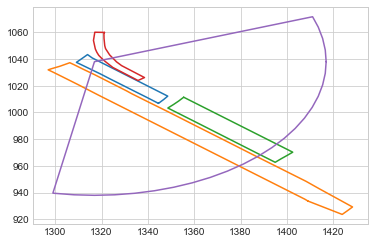

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x2c1bea520>, <shapely.geometry.polygon.Polygon object at 0x2c2200700>, <shapely.geometry.polygon.Polygon object at 0x2c2bfcee0>, <shapely.geometry.polygon.Polygon object at 0x2c2d99970>]


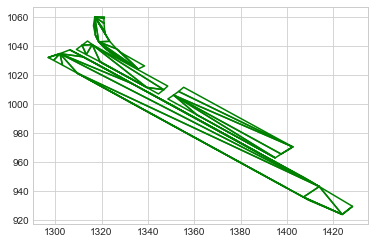

position is valid
heading:  4.008386039074258
within get_traffic_flow
point:  (1316.9486451760638 @ 1037.9575936034432)
heading output =  3.9882307082586825
NOT VALID: HEADING
VALID:  False


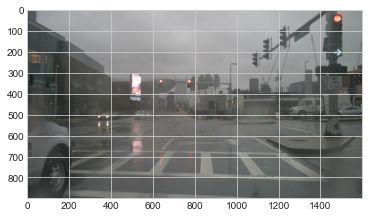

position:  (1006.1963328358183 @ 1261.8950026539942)


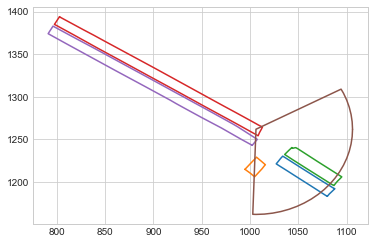

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x244fb0400>, <shapely.geometry.polygon.Polygon object at 0x2461684c0>, <shapely.geometry.polygon.Polygon object at 0x2c0e60970>, <shapely.geometry.polygon.Polygon object at 0x2c1ac9df0>, <shapely.geometry.polygon.Polygon object at 0x2c1b3b880>]


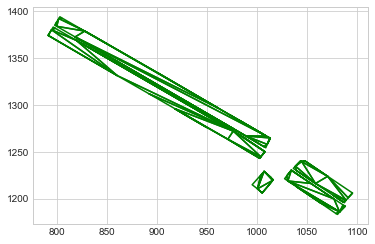

position is valid
heading:  4.1555428630928795
within get_traffic_flow
point:  (1006.1963328358183 @ 1261.8950026539942)
heading output =  4.158780958463948
NOT VALID: HEADING
VALID:  False


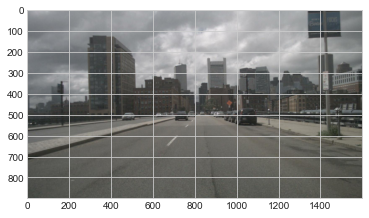

position:  (770.0659171415182 @ 421.2352666163001)


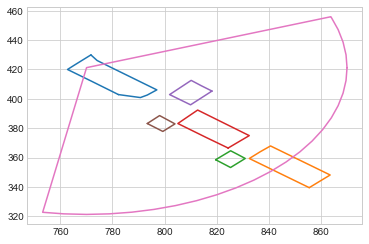

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x245959c40>, <shapely.geometry.polygon.Polygon object at 0x245f69760>, <shapely.geometry.polygon.Polygon object at 0x2606fe040>, <shapely.geometry.polygon.Polygon object at 0x2c1501100>, <shapely.geometry.polygon.Polygon object at 0x2c165da60>, <shapely.geometry.polygon.Polygon object at 0x2c1afce80>]


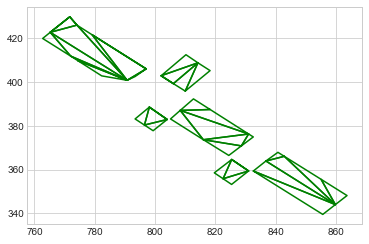

position is valid
heading:  4.019434680828833
within get_traffic_flow
point:  (770.0659171415182 @ 421.2352666163001)
heading output =  3.998104439752686
NOT VALID: HEADING
VALID:  False


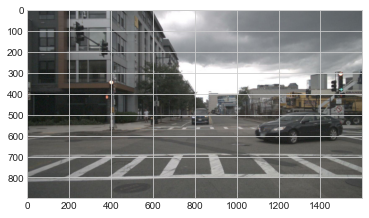

position:  (2132.568686693625 @ 897.8183453758336)


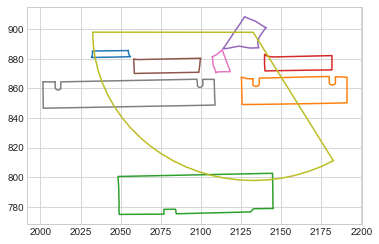

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x242972ee0>, <shapely.geometry.polygon.Polygon object at 0x244bf0730>, <shapely.geometry.polygon.Polygon object at 0x244f4aa30>, <shapely.geometry.polygon.Polygon object at 0x2469691f0>, <shapely.geometry.polygon.Polygon object at 0x261544610>, <shapely.geometry.polygon.Polygon object at 0x2c1395580>, <shapely.geometry.polygon.Polygon object at 0x2c251ec70>, <shapely.geometry.polygon.Polygon object at 0x2c26ef730>]


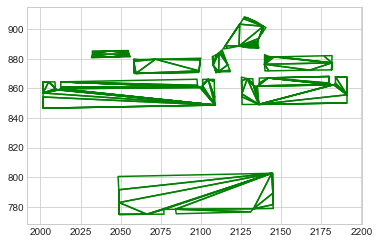

position is valid
heading:  2.617191725304397
within get_traffic_flow
point:  (2132.568686693625 @ 897.8183453758336)
heading output =  2.5984529909610243
NOT VALID: HEADING
VALID:  False


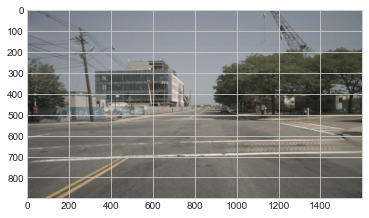

position:  (1869.0260373207707 @ 785.4157500240271)


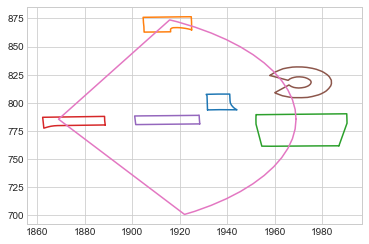

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x2450831f0>, <shapely.geometry.polygon.Polygon object at 0x245f8b490>, <shapely.geometry.polygon.Polygon object at 0x246833b20>, <shapely.geometry.polygon.Polygon object at 0x2bf20d190>, <shapely.geometry.polygon.Polygon object at 0x2c20f30d0>, <shapely.geometry.polygon.Polygon object at 0x2c2f7ed00>]


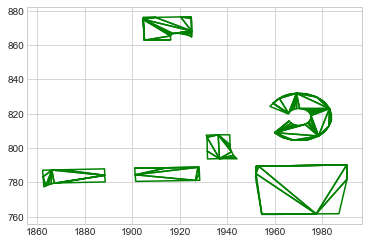

position is valid
heading:  -1.5346508893088013
within get_traffic_flow
point:  (1869.0260373207707 @ 785.4157500240271)
heading output =  -1.5388190071758103
NOT VALID: HEADING
VALID:  False


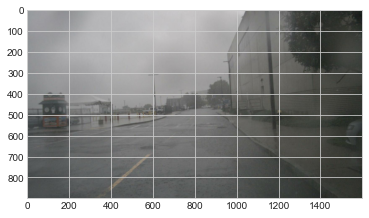

position:  (1185.1335359003983 @ 1134.8982167353256)


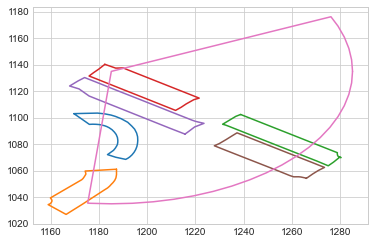

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x242064340>, <shapely.geometry.polygon.Polygon object at 0x2429b6670>, <shapely.geometry.polygon.Polygon object at 0x24612a700>, <shapely.geometry.polygon.Polygon object at 0x2607ebd90>, <shapely.geometry.polygon.Polygon object at 0x2c1a81490>, <shapely.geometry.polygon.Polygon object at 0x2c23e5700>]


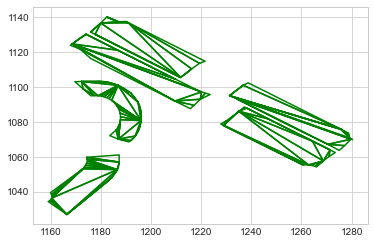

position is valid
heading:  4.090683068361336
within get_traffic_flow
point:  (1185.1335359003983 @ 1134.8982167353256)
heading output =  4.088358969129785
NOT VALID: HEADING
VALID:  False


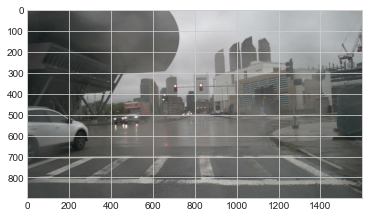

position:  (1488.105592954214 @ 1367.5406947523186)


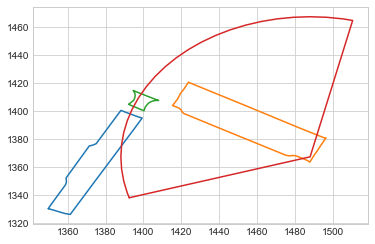

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x2467e9280>, <shapely.geometry.polygon.Polygon object at 0x2c2a8d820>, <shapely.geometry.polygon.Polygon object at 0x2c3841100>]


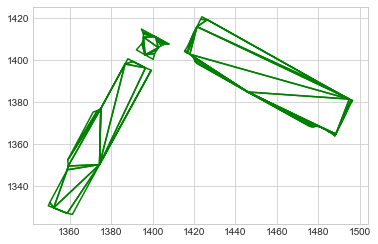

position is valid
heading:  0.8202083093129475
within get_traffic_flow
point:  (1488.105592954214 @ 1367.5406947523186)
heading output =  1.067287931227427
NOT VALID: HEADING
VALID:  False


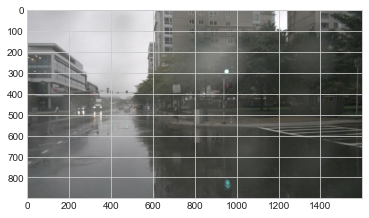

position:  (456.4160686739376 @ 810.1089609354069)


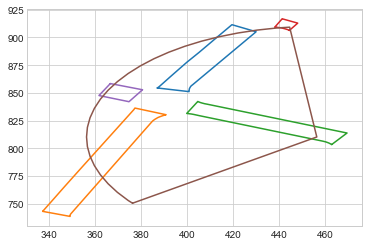

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x2420f1eb0>, <shapely.geometry.polygon.Polygon object at 0x2462e7070>, <shapely.geometry.polygon.Polygon object at 0x246765670>, <shapely.geometry.polygon.Polygon object at 0x2612e7760>, <shapely.geometry.polygon.Polygon object at 0x2bd2754f0>]


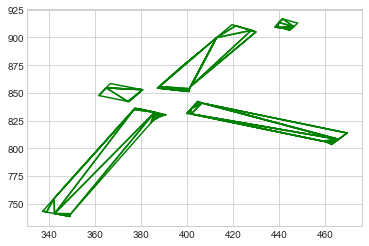

position is valid
heading:  1.165559112448674
within get_traffic_flow
point:  (456.4160686739376 @ 810.1089609354069)
heading output =  1.1585550135170142
NOT VALID: HEADING
VALID:  False


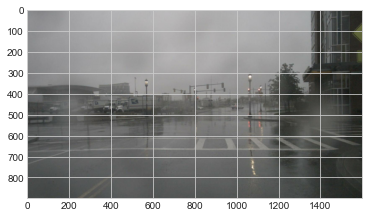

position:  (527.9398856403934 @ 1687.020558369616)


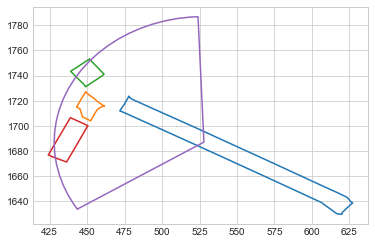

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x245a526a0>, <shapely.geometry.polygon.Polygon object at 0x24652c6a0>, <shapely.geometry.polygon.Polygon object at 0x2469bac70>, <shapely.geometry.polygon.Polygon object at 0x2c17b4eb0>]


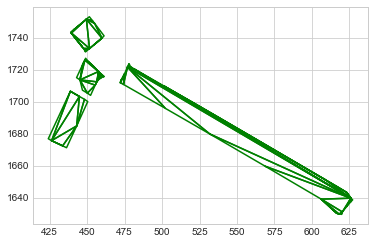

position is valid
heading:  1.086580776792314
within get_traffic_flow
point:  (527.9398856403934 @ 1687.020558369616)
heading output =  1.0614683158284812
NOT VALID: HEADING
VALID:  False


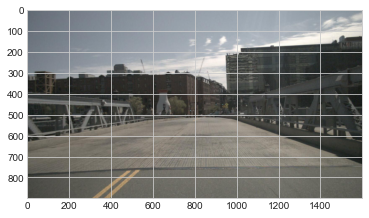

position:  (2188.7205342395423 @ 791.6347178701818)


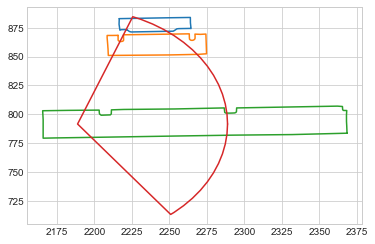

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x244b202e0>, <shapely.geometry.polygon.Polygon object at 0x244c95b80>, <shapely.geometry.polygon.Polygon object at 0x2c2c49610>]


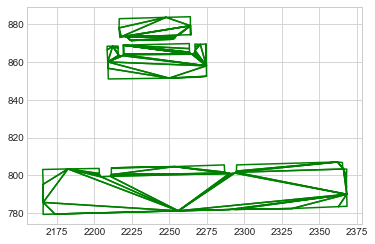

position is valid
heading:  -1.4241387562126244
within get_traffic_flow
point:  (2188.7205342395423 @ 791.6347178701818)
heading output =  -1.5500473188124233
NOT VALID: HEADING
VALID:  False


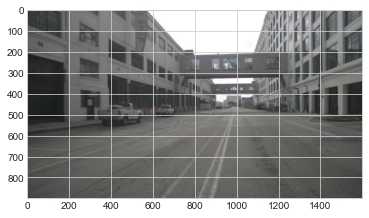

position:  (1917.357693367985 @ 1059.005429878575)


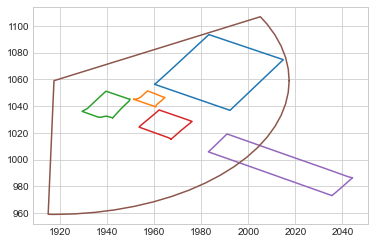

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x2464b0640>, <shapely.geometry.polygon.Polygon object at 0x246a4a6d0>, <shapely.geometry.polygon.Polygon object at 0x2bd258310>, <shapely.geometry.polygon.Polygon object at 0x2c15d0a90>, <shapely.geometry.polygon.Polygon object at 0x2c2416430>]


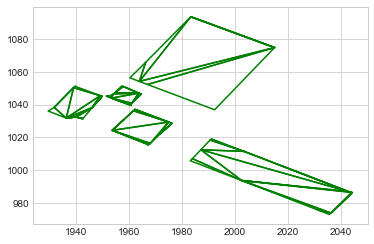

NOT VALID: POSITION
VALID:  False


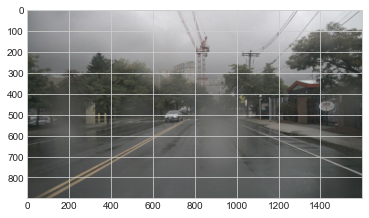

position:  (1197.0562191399388 @ 1390.497990643683)


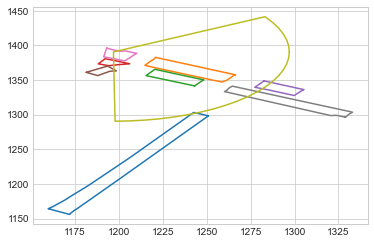

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x24214edc0>, <shapely.geometry.polygon.Polygon object at 0x245f3cca0>, <shapely.geometry.polygon.Polygon object at 0x2465bf490>, <shapely.geometry.polygon.Polygon object at 0x260a29670>, <shapely.geometry.polygon.Polygon object at 0x2611b9af0>, <shapely.geometry.polygon.Polygon object at 0x2c0ff3df0>, <shapely.geometry.polygon.Polygon object at 0x2c1cbad90>, <shapely.geometry.polygon.Polygon object at 0x2c278f640>]


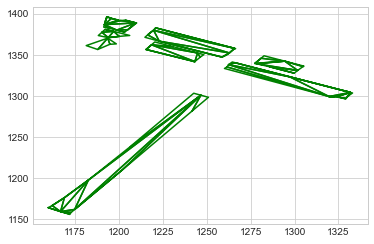

position is valid
heading:  4.198024953341729
within get_traffic_flow
point:  (1197.0562191399388 @ 1390.497990643683)
heading output =  4.2732128208192
NOT VALID: HEADING
VALID:  False


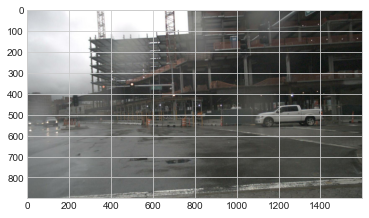

position:  (1866.915051802043 @ 1064.1207021443893)


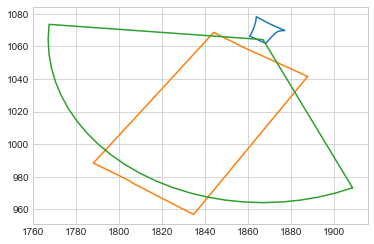

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x2421c3850>, <shapely.geometry.polygon.Polygon object at 0x246ba1580>]


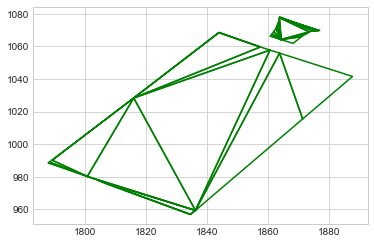

position is valid
heading:  2.524408790405437
within get_traffic_flow
point:  (1866.915051802043 @ 1064.1207021443893)
heading output =  2.4636758907231044
NOT VALID: HEADING
VALID:  False


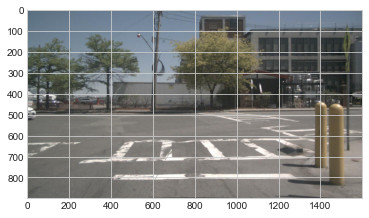

position:  (530.8184781885457 @ 1558.0398695842593)


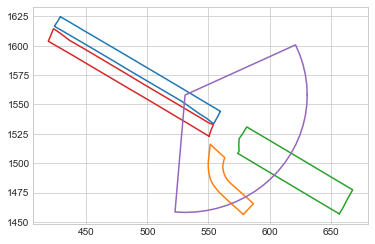

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x2465fc1f0>, <shapely.geometry.polygon.Polygon object at 0x2c2041a00>, <shapely.geometry.polygon.Polygon object at 0x2c21100d0>, <shapely.geometry.polygon.Polygon object at 0x2c2e8f8b0>]


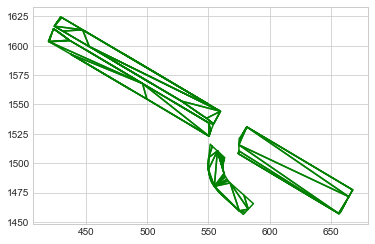

position is valid
heading:  4.1064222429552615
within get_traffic_flow
point:  (530.8184781885457 @ 1558.0398695842593)
heading output =  4.157322004217218
NOT VALID: HEADING
VALID:  False


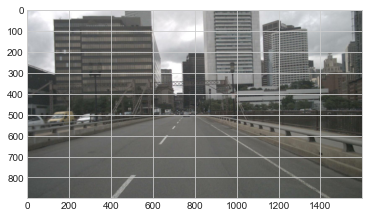

position:  (1669.4248019444874 @ 945.3035165750474)


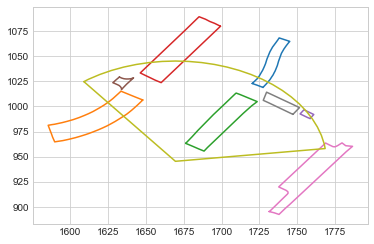

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x24497f370>, <shapely.geometry.polygon.Polygon object at 0x2451f4280>, <shapely.geometry.polygon.Polygon object at 0x24647da90>, <shapely.geometry.polygon.Polygon object at 0x246627b50>, <shapely.geometry.polygon.Polygon object at 0x26095da00>, <shapely.geometry.polygon.Polygon object at 0x261585cd0>, <shapely.geometry.polygon.Polygon object at 0x2c1e2cb20>, <shapely.geometry.polygon.Polygon object at 0x2c38013a0>]


KeyboardInterrupt: 

In [6]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_results'
subject1 = 'experiment_result_JayShenoy'
subject2 = 'experiment_result_TaeSung'
subject3 = 'experiment_result_Xiangyu'
scenario_list = ['scenario1','scenario2','scenario3','scenario4','scenario5']

dir3 = os.path.join(directory, 'data')
# dir3 = os.path.join(directory, subject3, 'scenario3')
filenames = [file for file in os.listdir(dir3) if file.endswith('.jpg')]
print(len(filenames))

if not os.path.isdir(os.path.join(directory, 'scenario3_queried')):
    os.mkdir(os.path.join(directory, 'scenario3_queried'))

for file in filenames:
    valid = validateLabel(scenario, file, debug=False, falseTesting=False, scenic_testing=False)
    print("VALID: ", valid)
#     if valid:  
#         shutil.copy(os.path.join(dir3, file), os.path.join(directory, 'scenario3_queried'))
    img = mpimg.imread(os.path.join(dir3, file))
    imgplot = plt.imshow(img)
    plt.show()
